### Image Data Inspection

**Q1. What is COCO?**

`COCO` stands for `Common Objects in Context`. It's a large, publicly available dataset of images used to train and test computer vision models for tasks like object detection and image segmentation.

**Q2. What does it Contain?**

The `COCO 2017` dataset contains hundreds of thousands of real-world photographs with detailed annotations. Each image typically has multiple objects of different types, and each object is carefully labeled with:

- A bounding box (rectangular border around the object)

- A segmentation mask (precise pixel-level outline of the object)

- The object's category/class name (e.g., "person", "car", "dog")

- Dataset Size:

  - 118,000 training images (for teaching the model)

  - 5,000 validation images (for testing during training)

  - 40,700 test images (for final model evaluation)

  - 80 object categories to detect (things like people, animals, vehicles, furniture, etc.)

  - Over 1.5 million labeled objects across all images

**Q3. How is it organized?**

The dataset has a folder structure with:

- Images folder: Contains actual `.jpg` image files

- Annotations folder: Contains `JSON` files with all the labeling information (bounding boxes, masks, categories, etc.)

#### Import Libraries and Set Paths
- Set up the environment by importing necessary libraries and defining the paths to your COCO dataset folders and annotation files.

In [3]:
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

# Path to extracted COCO dataset
coco_root = "../../../../img/raw/coco2017"  # e.g., "coco_2017"
images_dir = os.path.join(coco_root, "train2017")  # or val2017
annotations_file = os.path.join(coco_root, "annotations", "instances_train2017.json")

#### Load COCO Annotations
- Now load up the `COCO JSON` annotation file and parses it into Python dictionaries for efficient data access.

In [4]:
# Load COCO annotations
with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

# Create dictionaries for quick lookup
images_by_id = {img['id']: img for img in coco_data['images']}
categories_by_id = {cat['id']: cat for cat in coco_data['categories']}

# Group annotations by image_id
annotations_by_image = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_by_image:
        annotations_by_image[img_id] = []
    annotations_by_image[img_id].append(ann)

print(f"Total images: {len(coco_data['images'])}")
print(f"Total categories: {len(coco_data['categories'])}")
print(f"Total annotations: {len(coco_data['annotations'])}")

Total images: 118287
Total categories: 80
Total annotations: 860001


#### Display Dataset Statistics
- This function analyzes the entire dataset and prints statistics about object distribution across categories to understand dataset composition.


In [8]:
def print_dataset_stats():
    print("\n--- Dataset Statistics ---")
    category_counts = {}
    for ann in coco_data['annotations']:
        cat_id = ann['category_id']
        cat_name = categories_by_id[cat_id]['name']
        category_counts[cat_name] = category_counts.get(cat_name, 0) + 1
    
    print("\nObject counts per category (top 10):")
    sorted_cats = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for cat_name, count in sorted_cats:
        print(f"  {cat_name}: {count}")
print_dataset_stats()


--- Dataset Statistics ---

Object counts per category (top 10):
  person: 262465
  car: 43867
  chair: 38491
  book: 24715
  bottle: 24342
  cup: 20650
  dining table: 15714
  bowl: 14358
  traffic light: 12884
  handbag: 12354


#### Inspect Single Image with Annotations
- This core function that loads a specific image by ID and displays its metadata, objects, and visualizations with bounding boxes and segmentation masks.

In [14]:
def inspect_image_with_annotations(image_id, visualize_bbox=True, visualize_mask=True):
    # Load image
    image_info = images_by_id[image_id]
    image_path = os.path.join(images_dir, image_info['file_name'])
    image = Image.open(image_path).convert("RGB")
    
    # Print image info
    print(f"\n--- Image Inspection ---")
    print(f"Image ID: {image_id}")
    print(f"Filename: {image_info['file_name']}")
    print(f"Size: {image.size} (width x height)")
    print(f"Mode: {image.mode}")
    
    # Get annotations for this image
    annotations = annotations_by_image.get(image_id, [])
    print(f"Number of objects: {len(annotations)}")
    
    # Print object categories in this image
    print("\nObjects in this image:")
    for ann in annotations:
        cat_id = ann['category_id']
        cat_name = categories_by_id[cat_id]['name']
        bbox = ann['bbox']
        area = ann['area']
        print(f"  - {cat_name}: bbox={bbox}, area={area:.0f}px")
    
    # Visualize
    if visualize_bbox or visualize_mask:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image)
        
        # Draw bounding boxes
        if visualize_bbox:
            for ann in annotations:
                bbox = ann['bbox']
                x, y, w, h = bbox
                rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
                cat_id = ann['category_id']
                cat_name = categories_by_id[cat_id]['name']
                ax.text(x, y-5, cat_name, fontsize=8, color='red', 
                       bbox=dict(facecolor='white', alpha=0.7))
        
        # Draw segmentation masks
        if visualize_mask:
            for ann in annotations:
                if 'segmentation' in ann and len(ann['segmentation']) > 0:
                    seg = ann['segmentation'][0]  # Get first polygon
                    if isinstance(seg, list) and len(seg) > 4:
                        # Reshape to (N, 2) for polygon
                        polygon = np.array(seg).reshape(-1, 2)
                        poly = Polygon(polygon, alpha=0.3, color='blue')
                        ax.add_patch(poly)
        
        ax.axis('off')
        ax.set_title(f"Image ID: {image_id}")
        plt.tight_layout()
        plt.show()

#### Inspect Image by Index

- This helper function allows to inspect images by their position in the dataset (0, 1, 2, etc.) without needing to know the image ID.


--- Image Inspection ---
Image ID: 391895
Filename: 000000391895.jpg
Size: (640, 360) (width x height)
Mode: RGB
Number of objects: 4

Objects in this image:
  - motorcycle: bbox=[359.17, 146.17, 112.45, 213.57], area=12190px
  - person: bbox=[339.88, 22.16, 153.88, 300.73], area=14107px
  - person: bbox=[471.64, 172.82, 35.92, 48.1], area=708px
  - bicycle: bbox=[486.01, 183.31, 30.63, 34.98], area=627px


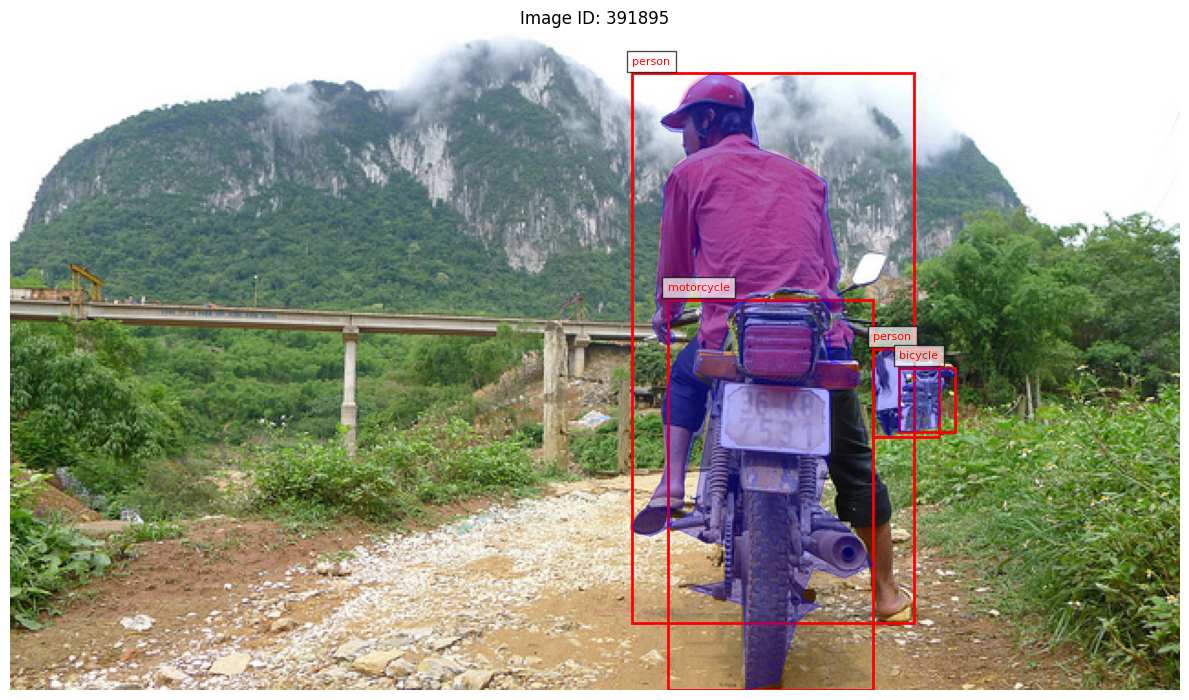

In [15]:
def inspect_image_by_index(index=0):
    image_ids = list(images_by_id.keys())
    if index < len(image_ids):
        image_id = image_ids[index]
        inspect_image_with_annotations(image_id, visualize_bbox=True, visualize_mask=True)
    else:
        print(f"Index {index} out of range. Total images: {len(image_ids)}")

inspect_image_by_index(index=0)

#### Inspect Random Images

- This function randomly selects and inspects multiple images from the dataset to get a diverse view of different samples.


--- Image Inspection ---
Image ID: 366508
Filename: 000000366508.jpg
Size: (591, 640) (width x height)
Mode: RGB
Number of objects: 1

Objects in this image:
  - bear: bbox=[243.95, 175.0, 172.19, 325.74], area=38699px


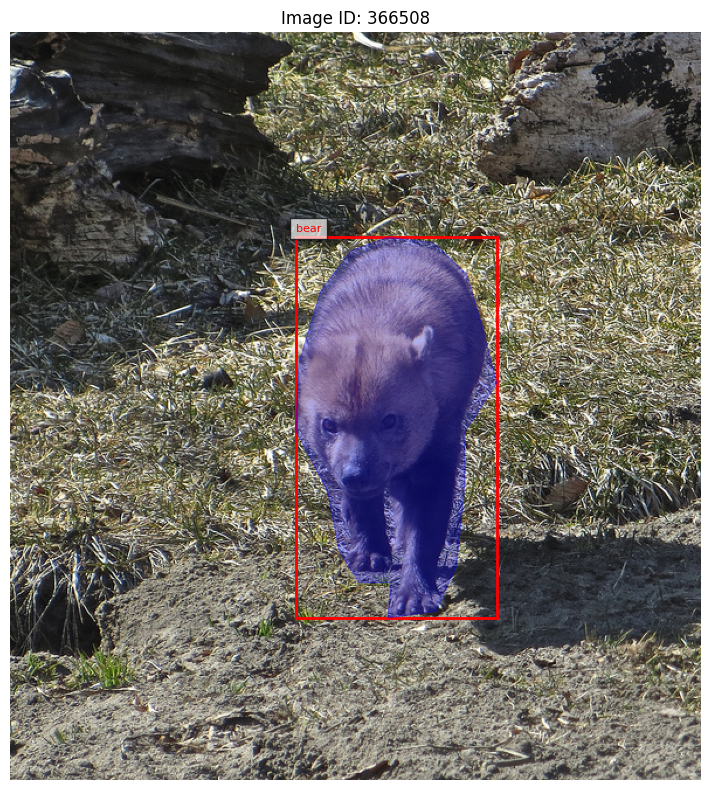


--- Image Inspection ---
Image ID: 547487
Filename: 000000547487.jpg
Size: (400, 600) (width x height)
Mode: RGB
Number of objects: 7

Objects in this image:
  - person: bbox=[217.68, 425.17, 22.6, 27.07], area=405px
  - person: bbox=[14.83, 88.99, 361.35, 264.27], area=31337px
  - person: bbox=[262.48, 418.17, 19.67, 28.59], area=381px
  - person: bbox=[327.07, 415.74, 23.1, 28.63], area=388px
  - skateboard: bbox=[44.04, 365.15, 240.02, 74.04], area=12557px
  - person: bbox=[240.1, 424.84, 18.1, 25.49], area=390px
  - person: bbox=[283.33, 423.61, 31.25, 20.92], area=288px


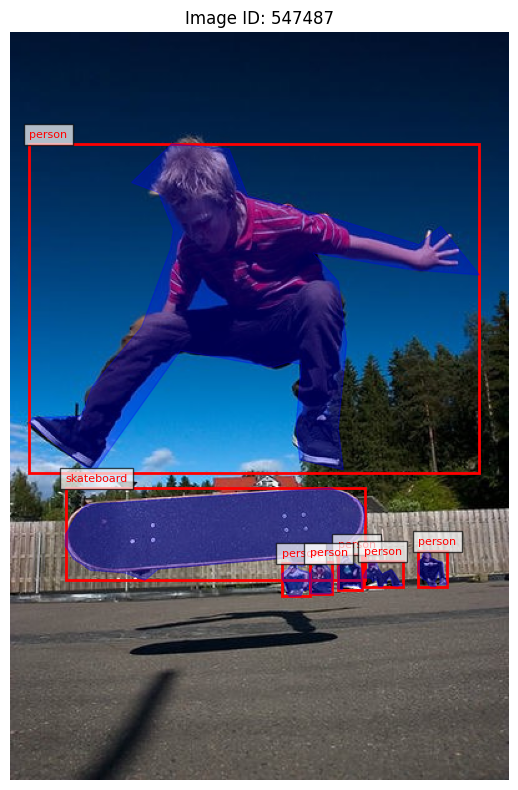


--- Image Inspection ---
Image ID: 516043
Filename: 000000516043.jpg
Size: (640, 428) (width x height)
Mode: RGB
Number of objects: 3

Objects in this image:
  - bed: bbox=[0.0, 102.54, 182.88, 316.94], area=26499px
  - person: bbox=[172.35, 116.99, 467.26, 310.23], area=72336px
  - cup: bbox=[129.37, 233.57, 33.71, 42.14], area=1055px


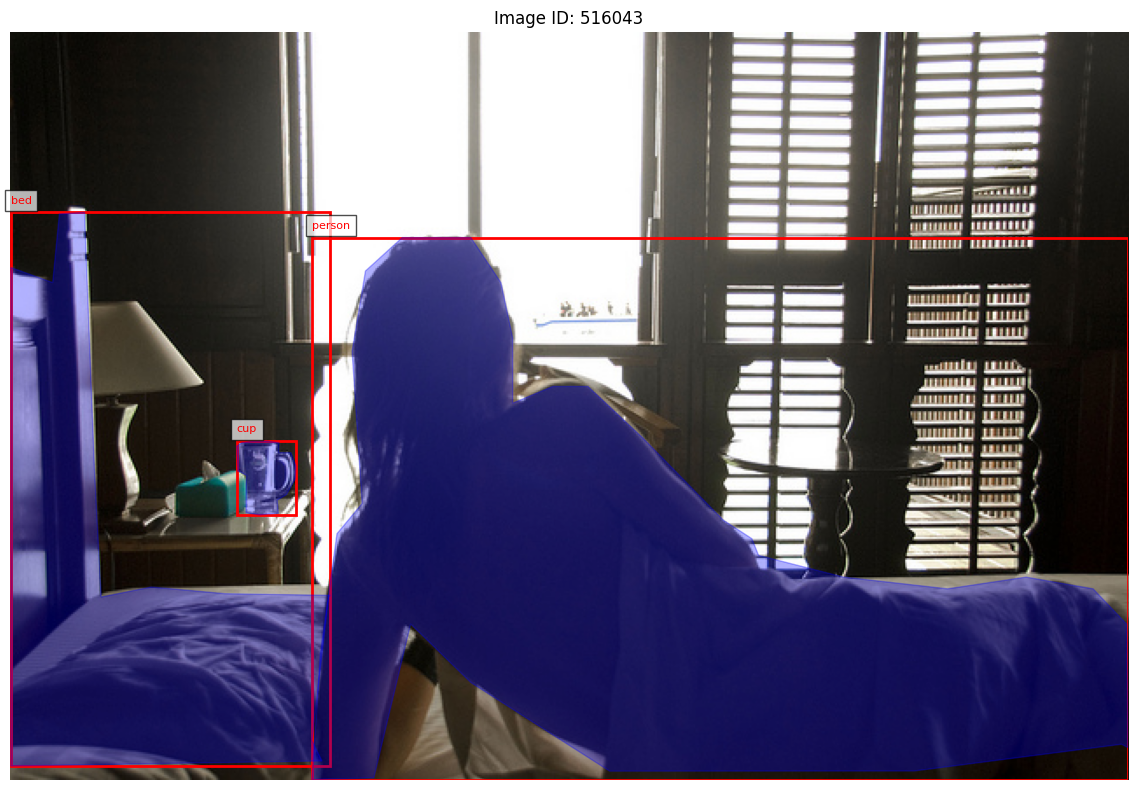

In [16]:
def inspect_random_images(num_samples=3):
    import random
    random_image_ids = random.sample(list(images_by_id.keys()), num_samples)
    
    for img_id in random_image_ids:
        inspect_image_with_annotations(img_id, visualize_bbox=True, visualize_mask=True)

inspect_random_images(num_samples=3)